# Spectral line sensitivity

First, Tsys as a function of frequency:

Populating the interactive namespace from numpy and matplotlib


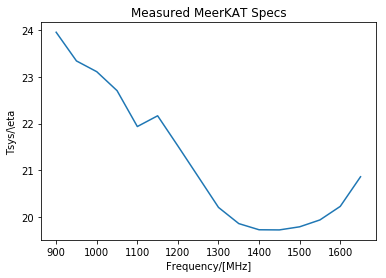

In [1]:
%pylab inline
import numpy as np

# Fitted values from recent work.
specs = np.array([[ 900.        ,   23.95144954],
       [ 950.        ,   23.33837709],
       [1000.        ,   23.10850831],
       [1050.        ,   22.70384223],
       [1100.        ,   21.93645197],
       [1150.        ,   22.16621671],
       [1200.        ,   21.52095707],
       [1250.        ,   20.86545365],
       [1300.        ,   20.20854385],
       [1350.        ,   19.86267232],
       [1400.        ,   19.73085187],
       [1450.        ,   19.72759109],
       [1500.        ,   19.79424543],
       [1550.        ,   19.94109374],
       [1600.        ,   20.23018655],
       [1650.        ,   20.86337011]])
plt.plot(specs[:,0],specs[:,1])
plt.title('Measured MeerKAT Specs')
plt.ylabel('Tsys/\eta')
i=plt.xlabel('Frequency/[MHz]')

In [2]:
k = 1.38e-23
J = 1e26                                   # Jy to Watts conversion factor
f = specs[:,0]*1e6                         # frequency axis above, Hz
lam = 3e8/f                                # corresponding wavelengths
c = 2.99792456e5
print('4k mode channel width : {0:f} km/s '.format(209000*c/1421e6 ))

4k mode channel width : 44.093331 km/s 


For reference, the calculations that went into this are:

\begin{align*}
\frac{\Delta\nu}{\Delta velo } = \frac{\nu_{rest}}{c} 
\end{align*}
\begin{align*}
\nu_{rest} = 1421.0 MHz
\end{align*}

\begin{align*}
c = 2.99792456e+05 km.s^{-1} 
\end{align*}
\begin{align*}
\Delta velo = 16 km.s^{-1}
\end{align*}
\begin{align*}
\Delta\nu = 75807.4180101 Hz
\end{align*}
A 5 sigma sensitivity in the intensity of an image is found using 
\begin{align*}5\sigma_{S} = 5 \frac{2 k T_{sys}}{A_{eff} [2N(N-1)\Delta \nu_{\rm RF}\tau]^{1/2}}
\end{align*}


equations from http://www.atnf.csiro.au/people/Tobias.Westmeier/tools_hihelpers.php
\begin{align*}
 T_{\rm B} = \frac{606 \, S}{\vartheta^{2}}
\end{align*}
theta  is in arcseconds  , and the flux is in mJy
\begin{align*}
N_{\rm H\,I} = 1.823 \times 10^{18} \! \int \! T_{\rm B} \, \mathrm{d}v          
 \end{align*}         
dv  is in km.s^{-1}


In [3]:
# Parameters to adjust for the observation 
F_tap = 1.6          # The Robust/tapering factor.
theta = 60.          # The beam size in arcseconds  
N_hi = 1e19          #  HI column Density cm^{-2}
SN = 3               # Signal to Noise for detection
hours = 16            # Time in Hours
N = 58               # Number of Antennas
velocity_width = 44. # in km.s^1 
obs_freq =1.421e9    # Observation frequency in Hz

Use the cell below to compute the flux of a spectral feature:

In [4]:
print('Flux of a column density:')
delta_v = velocity_width 
col_flux = N_hi*theta**2/(1.823e18*606.*delta_v)
string1 = "N_hi = {0:2.4g} at {1} arc-seconds  with a velocity width of {2:2.4g} km/s, has a flux of {3:2.4g} mJy. "
string2 = "To detect this at a {1:.0f}-sigma level (taper factor of {2:2.2g}),\nwe would need an image with a natural rms of {3:2.4g} mJy"
print(string1.format(N_hi,theta,velocity_width,col_flux))
print(string2.format(N_hi,SN,F_tap,col_flux/(F_tap*SN)))

Flux of a column density:
N_hi = 1e+19 at 60.0 arc-seconds  with a velocity width of 44 km/s, has a flux of 0.7406 mJy. 
To detect this at a 3-sigma level (taper factor of 1.6),
we would need an image with a natural rms of 0.1543 mJy


Use the cell below to compute the image rms (single-channel), and resulting detection level:

In [5]:
sigma = SN 
D = 13.5             # Meters
h1 = 1420405751.7667 # Hz
NPol = 2
A = np.pi * (D/2)**2
Tsys_eta = specs[:,1]
bw = h1/c*velocity_width    
tau = 3600 * hours
Tsys_per_eta = Tsys_eta[np.argmin(np.abs(f - obs_freq))]
print ("T_sys/eta at %3.0f MHz is %2.1fK"%(obs_freq/1e6,Tsys_per_eta) )
print("Flux/rms calculated from the observing time: ")
noise = 2 * k * Tsys_per_eta / (A * np.sqrt(N * (N-1) * bw * tau)) * J / np.sqrt(NPol) 
#rms_L =  2 * k * Tsys_eta_L / (A * sqrt(N * (N-1) * bw_L * tau)) * J / sqrt(NPol)
print("Natural rms noise after {:.1f}h on-source is {:2.4g} mJy".format(hours, noise*1e3)) 
print("With a taper factor of {:.1f}, this becomes {:2.4g} mJy".format(F_tap, F_tap*noise*1e3)) 
print("The {:.0f}-sigma detection level is then {:2.4g} mJy".format(sigma, sigma*F_tap*noise*1e3))

T_sys/eta at 1421 MHz is 19.7K
Flux/rms calculated from the observing time: 
Natural rms noise after 16.0h on-source is 0.0427 mJy
With a taper factor of 1.6, this becomes 0.06832 mJy
The 3-sigma detection level is then 0.2049 mJy
